In [1]:
from google.colab import drive 
drive.mount('/content/myfiles')

Mounted at /content/myfiles


In [2]:
%cd "/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation"
!pwd

/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation
/content/myfiles/MyDrive/Politechnika/GSN/gsn-2022z-hand-segmentation


In [ ]:
!git fetch
#!git pull

In [ ]:
!git add skinny_no_i_d.ipynb

In [ ]:
!git commit -m "Begin implementation of learning procedur"

[main b759318] Small corrections to the model
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite skinny_no_i_d.ipynb (89%)


In [ ]:
!git push

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.38 KiB | 282.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
To https://gitlab-stud.elka.pw.edu.pl/mmarcin5/gsn-2022z-hand-segmentation.git
   1feaa1c..b759318  main -> main


In [3]:
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as transforms
import torch

# dataloader
class SkinDataset(Dataset):
    def __init__(self, description_file, out_size, transform_image=None, 
                 target_transform=None):
        self.images_file = pd.read_csv(description_file)
        self.transform_image = transform_image
        self.target_transform = target_transform
        self.size = out_size
        self.resize = transforms.Resize(self.size)

    def __len__(self):
        return len(self.images_file)

    def __getitem__(self, idx):
        img_path = self.images_file.iloc[idx, 0]
        image = read_image(img_path)
        w = image.size()[1]
        h = image.size()[2]

        if(w > h):
          diff = w - h
          pad = (0, diff, 0, 0)
        else:
          diff = h - w
          pad = (0, 0, 0, diff)
        if self.transform_image:
            image = self.transform_image(image.to(torch.float64))
        image = torch.nn.functional.pad(image, pad, mode='constant', value=1)
        image = self.resize(image)

        label_path = self.images_file.iloc[idx, 1]
        label = Image.open(label_path)
        if self.target_transform:
            label = self.target_transform(label)
        label = torch.nn.functional.pad(label, pad, mode='constant', value=1)
        label = self.resize(label)
        label_one_hot = torch.nn.functional.one_hot(label.to(torch.int64), 2).transpose(1, 3).squeeze().permute(0, 2, 1)


        return image, label_one_hot


In [16]:
padding_mode = 'same'

In [17]:
import torch.nn as nn
import torch.nn.functional as F

# first part - double convolution
class InitConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.sequential_stack = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels)
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [18]:
# downscaling - double convolution with max pooling
class ConvDown(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.sequential_stack = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels)
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [19]:
# upscaling - double convolution with convolution transpose and concatenation
class DeconvUp(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    mid_channels = out_channels // 2

    self.sequential_stack = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ConvTranspose2d(in_channels=out_channels, out_channels=mid_channels, 
                           stride=2, kernel_size=3),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x1, x2):
    x1 = self.sequential_stack(x1)
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    return torch.cat([x2, x1], dim=1)

In [20]:
# final module with several convolution layers finished with sigmoid
class FinalConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(FinalConv, self).__init__()

    mid_channels = in_channels // 2

    self.sequential_stack = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels // 2, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=mid_channels // 2, out_channels=out_channels, 
                  padding=padding_mode, kernel_size=3, bias=False),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [21]:
class AdditionalLayers(nn.Module):
  def __init__(self):
    super().__init__()

    self.sequential_stack = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2)
    )
  
  def forward(self, x):
    return self.sequential_stack(x)

In [28]:
# Skinny architecture variant without inception modules and dense blocks
class Skinny(nn.Module):
  def __init__(self, n_channels, n_classes):
    super(Skinny, self).__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes

    self.init = (InitConv(self.n_channels, 15))

    self.conv_down1 = (ConvDown(15, 30))
    self.conv_down2 = (ConvDown(30, 60))
    self.conv_down3 = (ConvDown(60, 120))
    self.conv_down4 = (ConvDown(120, 240))

    self.additional = (AdditionalLayers())

    self.deconv_up1 = (DeconvUp(240, 480))
    self.deconv_up2 = (DeconvUp(480, 240))
    self.deconv_up3 = (DeconvUp(240, 120))
    self.deconv_up4 = (DeconvUp(120, 60))
    self.deconv_up5 = (DeconvUp(60, 30))

    self.final = (FinalConv(30, n_classes))
  
  def forward(self, x):
    #print("Encoder")
    #print(x.shape)
    x1 = self.init(x)
    #print(x1.shape)
    x2 = self.conv_down1(x1)
    #print(x2.shape)
    x3 = self.conv_down2(x2)
    #print(x3.shape)
    x4 = self.conv_down3(x3)
    #print(x4.shape)
    x5 = self.conv_down4(x4)
    #print(x5.shape)
    x6 = self.additional(x5)
    #print(x6.shape)
    # x6 = F.relu(x5, True)
    # x7 = F.max_pool2d(x6, 2)

    #print("Decoder")
    x7 = self.deconv_up1(x6, x5)
    #print(x7.shape)
    x8 = self.deconv_up2(x7, x4)
    #print(x8.shape)
    x9 = self.deconv_up3(x8, x3)
    #print(x9.shape)
    x10 = self.deconv_up4(x9, x2)
    #print(x10.shape)
    x11 = self.deconv_up5(x10, x1)
    #print(x11.shape)
    
    output = self.final(x11)
    #print(output.shape)

    return output

In [40]:
SMOOTH = 1e-6
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    

In [10]:
mean = torch.tensor([48.1431, 47.4175, 42.4370], dtype=torch.float64)
std = torch.tensor([45.2122, 40.2552, 37.7503], dtype=torch.float64)

transform_label = transforms.Compose([transforms.ToTensor()])
transform_image = transforms.Compose([transforms.Normalize(mean, std)])

data_1 = SkinDataset("data_type1.csv", 512, transform_image, transform_label)
data_2a = SkinDataset("data_type2a.csv", 512, transform_image, transform_label)
data_2b = SkinDataset("data_type2b.csv", 512, transform_image, transform_label)
data_all = torch.utils.data.ConcatDataset([data_1, data_2a, data_2b])

In [23]:
import numpy as np

train_percent = 0.8
train_len_1 = int(np.floor(train_percent * len(data_1)))
train_len_2a = int(np.floor(train_percent * len(data_2a)))
train_len_2b = int(np.floor(train_percent * len(data_2b)))

train_1, test_1 = torch.utils.data.random_split(data_1, [train_len_1, len(data_1) - train_len_1], generator=torch.Generator().manual_seed(42))
train_2a, test_2a = torch.utils.data.random_split(data_2a, [train_len_2a, len(data_2a) - train_len_2a], generator=torch.Generator().manual_seed(42))
train_2b, test_2b = torch.utils.data.random_split(data_2b, [train_len_2b, len(data_2b) - train_len_2b], generator=torch.Generator().manual_seed(42))

data_train_val = torch.utils.data.ConcatDataset([train_1, train_2a, train_2b])
data_test = torch.utils.data.ConcatDataset([test_1, test_2a, test_2b])


val_percent = 0.15
val_len = int(np.floor(val_percent * len(data_train_val)))
data_train, data_val = torch.utils.data.random_split(data_train_val, 
                                                     [len(data_train_val) - val_len, val_len], 
                                                     generator=torch.Generator().manual_seed(42))

In [33]:
from torch.utils.data import DataLoader

val_loader = DataLoader(data_val, shuffle=True, batch_size=2)
train_loader = DataLoader(data_train, shuffle=True, batch_size=2)

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Skinny(3, 2)
model.to(device=device)
epochs = 50
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, foreach=True)

In [26]:
model

Skinny(
  (init): InitConv(
    (sequential_stack): Sequential(
      (0): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv_down1): ConvDown(
    (sequential_stack): Sequential(
      (0): ReLU(inplace=True)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (6): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, tra

In [62]:
batch = next(iter(train_loader))

for epoch in range(1, epochs + 1):
  model.train()
  epoch_loss = 0

  for i in [1]:
    images, masks = batch[0], batch[1]


    images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
    masks = masks.to(device=device, dtype=torch.float32)

    logits = model(images)

    # print(logits.shape)
    # print(masks.shape)

    loss = criterion(logits, masks)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(loss)

    # with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
    #     masks_pred = model(images)
    #     if model.n_classes == 1:
    #         loss = criterion(masks_pred.squeeze(1), true_masks.float())
    #         loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
    #     else:
    #         loss = criterion(masks_pred, true_masks)
    #         loss += dice_loss(
    #             F.softmax(masks_pred, dim=1).float(),
    #             F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
    #             multiclass=True
    #         )

    # optimizer.zero_grad(set_to_none=True)
    # grad_scaler.scale(loss).backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
    # grad_scaler.step(optimizer)
    # grad_scaler.update()

    # global_step += 1
    # epoch_loss += loss.item()
    # experiment.log({
    #     'train loss': loss.item(),
    #     'step': global_step,
    #     'epoch': epoch
    # })

    # # Evaluation round
    # division_step = (n_train // (5 * batch_size))
    # if division_step > 0:
    #     if global_step % division_step == 0:
    #         histograms = {}
    #         for tag, value in model.named_parameters():
    #             tag = tag.replace('/', '.')
    #             if not torch.isinf(value).any():
    #                 histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
    #             if not torch.isinf(value.grad).any():
    #                 histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

    # val_score = evaluate(model, val_loader, device, amp)
    # scheduler.step(val_score)

    # logging.info('Validation Dice score: {}'.format(val_score))
    # try:
    #     experiment.log({
    #         'learning rate': optimizer.param_groups[0]['lr'],
    #         'validation Dice': val_score,
    #         'images': wandb.Image(images[0].cpu()),
    #         'masks': {
    #             'true': wandb.Image(true_masks[0].float().cpu()),
    #             'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
    #         },
    #         'step': global_step,
    #         'epoch': epoch,
    #         **histograms
    #     })
    # except:
    #     pass

tensor(0.6953, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6907, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6851, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6786, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6704, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6611, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6513, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6405, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6274, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6124, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5960, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5780, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5590, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5389, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5181, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4969, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4754, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4545, device='cuda:0', grad_fn=<DivBack

Text(0.5, 1.05, 'class 1')

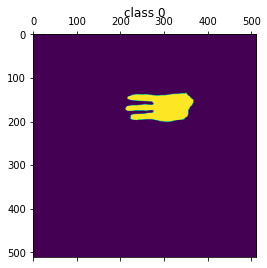

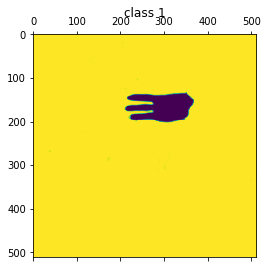

In [63]:
import matplotlib.pyplot as plt
lab  = logits[0]
plt.matshow(np.squeeze(lab[[0]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 0")
plt.matshow(np.squeeze(lab[[1]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 1")
#iou = iou_pytorch(logits, masks)

Text(0.5, 1.05, 'class 1')

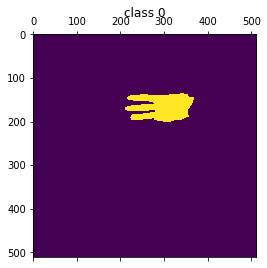

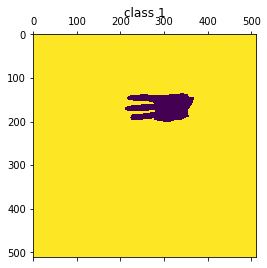

In [64]:
import matplotlib.pyplot as plt
mas  = masks[0]
plt.matshow(np.squeeze(mas[[0]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 0")
plt.matshow(np.squeeze(mas[[1]].permute(1, 2, 0).cpu()).detach().numpy())
plt.title("class 1")